In [1]:
#数据预处理
%matplotlib inline
import numpy as np
#import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno

#不加下面这一步进程很容易中断
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["OMP_NUM_THREADS"] = '9' 

#---------------------------------------------------
import sklearn
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
#加载模型：
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#---------------------------
from sklearn.model_selection import GridSearchCV

In [2]:
#网络调参函数 for img+sub
def get_model(name):
    if name=="SVC":
        clf=GridSearchCV(
            svm.SVC(),
            {
                #核
                "kernel": ['linear', "poly"],
                #惩罚系数
                "C": [0.01,0.1,1]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="DT":
        clf=GridSearchCV(
            tree.DecisionTreeClassifier(),
            {
                #划分方式
                "criterion": ['entropy',"gini"],#前者是基尼系数，后者是信息熵
                #z最大深度
                "max_depth": [2,10,50,100,200,500] ,
                #可以分支的最少样本数
                "min_samples_split": [1,5,10,20] ,
                #叶节点最小样本数
                "min_samples_leaf": [1,5,10,20] ,
                #信息增益最小值
                "min_impurity_decrease": [0.001,0.01]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="LR":
        clf = GridSearchCV(
            linear_model.LogisticRegression(),
            {
                "penalty":[None,'l2',"l1"],
                "C":[1,2,3,4,5,6,7,8,9,10],
                "solver":["newton-cg", "lbfgs", "liblinear", "sag"],
                "class_weight":["balanced",None]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="NB":
        clf = GridSearchCV(
            GaussianNB(),
            {},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
        
    if name=="KNN":
        clf = GridSearchCV(
            KNeighborsClassifier(),
            {
                "n_neighbors": [3,5,10,12]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="RF":
        clf = GridSearchCV(
            RandomForestClassifier(),
            {
                "n_estimators" : [8],#[10,15,20,25,30],
                "criterion" : ["entropy","gini"],
                "max_depth" : [2,3,4],#[8,12,16,20],
                #"min_samples_split" : [2,3,4,5],
                "min_samples_leaf" : [1,2,3,4,5]
            },
            #{
            #    "n_estimators" : [10,20,30,50,80],
            #    "criterion" : ["entropy","gini"],
            #    "max_depth" : [4,8,12,None],
            #    "min_samples_split" : [2,5,10],
            #    "min_samples_leaf" : [1,5,10,20]
            #},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="XB":
        clf=GridSearchCV(
            XGBClassifier(),
            {
                "n_estimators":[5,10,15,20],  # 树的个数-10棵树建立xgboost
                "max_depth":[6,12,18,24,30],  # 树的深度[4,8,12]
                "min_child_weight":[0.5,0.6,0.7],#叶子上最小样本数,值越大，越容易欠拟合；值越小，越容易过拟合
                "scale_pos_weight":[2.4,2.5],#各类别样本十分不平衡时，把这个参数设定为一个正值
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    return clf

In [3]:
#一些函数
# get_train_test
# get_dat->train_model
# model

#获得划分后的数据
def get_train_test(df,fold,seed):
    # 获取数据总行数
    nums = df.shape[0]
    # 将数据分成5份 if fold=5
    chunk_size = nums // fold
    print("样本总数：",nums)
    print("划分后每折样本数：",chunk_size)

    # 将数据打乱顺序  并  划分
    df_shuffled = df.sample(frac=1, random_state=seed)
    chunks = [df_shuffled.iloc[i:i + chunk_size] for i in range(0, nums, chunk_size)]

    if fold==3:
        train = [pd.concat([chunks[0],chunks[1]]),
                 pd.concat([chunks[0],chunks[2]]),
                 pd.concat([chunks[1],chunks[2]]),
                ]
        test = [chunks[2],chunks[1],chunks[0]]
        
    
    #获得五组训练集和训练集
    if fold==5:
        train = [pd.concat([chunks[0],chunks[1],chunks[2],chunks[3]]),
                 pd.concat([chunks[0],chunks[1],chunks[2],chunks[4]]),
                 pd.concat([chunks[0],chunks[1],chunks[3],chunks[4]]),
                 pd.concat([chunks[0],chunks[2],chunks[3],chunks[4]]),
                 pd.concat([chunks[1],chunks[2],chunks[3],chunks[4]]),
                ]
        test = [chunks[4],chunks[3],chunks[2],chunks[1],chunks[0]]
    return train,test

#获得分折好的数据集
def get_data(data,name):
    train_data = data #train[0] / test[0]
    target_name = name #"y4"
    #读
    df= train_data
    features=df.columns.tolist()
    features.remove( target_name )
    y=df[ target_name ]
    X=df[features].values
    return X,y




#获得用于绘制ROC的clf X y
def train_model(data_num,target_name,**dic):
    """
    data_num: 0~5
    target_name: str
    **dic: dic["name"]-> name of model
           ......
    #传参
    # https://blog.csdn.net/yyykj/article/details/103122665
    """
    #读取数据------train
    #X,y = get_data(train[data_num],target_name)
 
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    
    #读取数据------test
    X,y = get_data(test[data_num],target_name)
    return clf,X,y #用于后续进行ROC画图


#这个是 非多折交叉验证的建模
def train_model_(df1,df2,target_name,**dic):
    #读取数据------train
    #X,y = get_data(df1,target_name)
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    
    #读取数据------test
    X,y = get_data(df2,target_name)
    return clf,X,y #用于后续进行ROC画图

In [4]:
#读取最开始的数据
fpath="./lasso/8_train_score_med.xlsx"
df=pd.read_excel(fpath)

#用于在独立测试集上检验
fpath="./lasso/8_train_score_med.xlsx"
df1=pd.read_excel(fpath)

fpath="./lasso/9_test_score_med.xlsx"
df2=pd.read_excel(fpath)

In [5]:
df
print(df.shape,df1.shape,df2.shape)

(160, 9) (160, 9) (58, 9)


In [ ]:
warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in [1]:#range(0,50):#[1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    
    
    auc_record = []
    #"""

    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
        
    #"""
    
    #"""
    auc_record_ = []
    print("##############")
    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i in range(1):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""
    input()

----------------------------seed: 1
样本总数： 160
划分后每折样本数： 53
XB 0.85


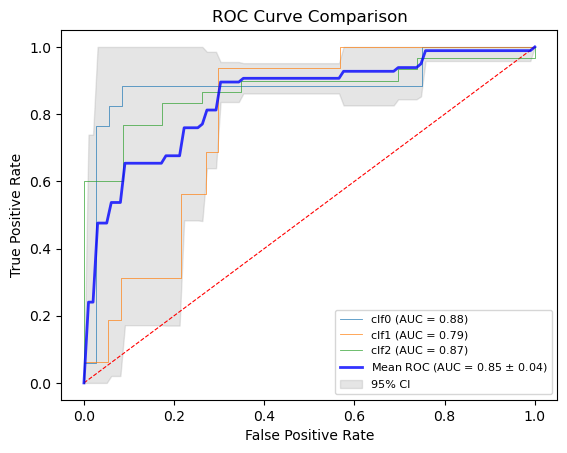

##############
XB 0.76


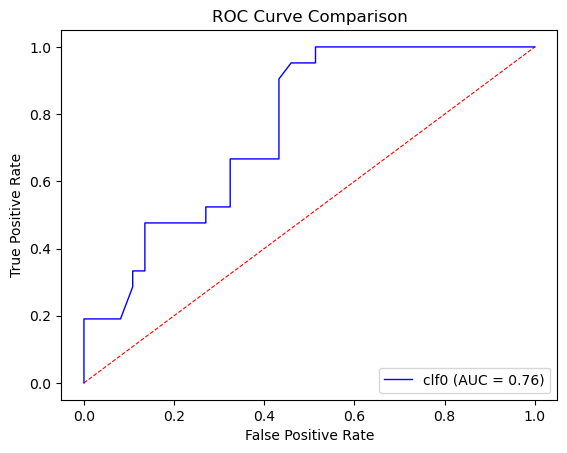

In [13]:
#最终画图

warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in [1]:#range(0,50):#[1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    
    
    auc_record = []
    #"""

    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label="95% CI")#r'$\pm$ 1 std. dev.'


        ax.legend(loc="lower right",fontsize=8)

        plt.title('ROC Curve Comparison')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        #------------------------------------------
    #"""
    
    #"""
    auc_record_ = []
    print("##############")
    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i in range(1):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=1, linewidth=1, color='b')

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        #std_auc = np.std(aucs)
        #ax.plot(mean_fpr, mean_tpr, color='b',
        #        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        #        lw=2, alpha=.8)

        #std_tpr = np.std(tprs, axis=0)
        #tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        #tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        #ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #               label="95% CI")#r'$\pm$ 1 std. dev.'


        #ax.legend(loc="lower right",fontsize=8)

        plt.title('ROC Curve Comparison')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        #------------------------------------------
        
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""
    #input()